In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
import simfin as sf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

time: 1.3 s (started: 2022-10-10 18:00:35 +08:00)


In [2]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

time: 0 ns (started: 2022-10-10 18:00:36 +08:00)


In [3]:
# Read in stock price fundamental ratios (38,307 rows)
X = pickle.load(open('./data/fundamentals3.pkl', 'rb'))

# Read in annual performance (38,307 rows)
y = pickle.load(open('./data/performance3.pkl', 'rb'))
y = y['Returns']

# Read in annual prices (38,307 rows)
y_withdata = pickle.load(open('./data/performance2.pkl', 'rb'))

# Convert to date
y_withdata["Date1"] = pd.to_datetime(y_withdata["Date1"])
y_withdata["Date2"] = pd.to_datetime(y_withdata["Date2"])

# X and Y Train and Test sets(splitting for train/test done previously for trained model)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

# Get y_withdata to correspond to y_test (subset of y_test)
y_withdata_test = pd.DataFrame()
y_withdata_test = y_withdata.loc[y_test.index, :]

# Convert string to datetime
y_withdata_test["Date1"] = pd.to_datetime(y_withdata_test["Date1"])
y_withdata_test["Date2"] = pd.to_datetime(y_withdata_test["Date2"])

time: 109 ms (started: 2022-10-10 18:00:36 +08:00)


In [4]:
# def getYRawData(directory='C:/Users/G50/Stock_Data/SimFin2021/'):
#     '''
#     Can set directory to look for file in.
#     Get daily stock price time series for ALL stocks. 
#     5M rows. Some days missing.
#     Returns DataFrame
#     '''
#     daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
#                                    delimiter=';')
#     daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
#     print('Reading historical time series stock data, matrix size is: ', 
#           daily_stock_prices.shape)
#     return daily_stock_prices

time: 0 ns (started: 2022-10-10 18:00:36 +08:00)


In [5]:
# Set your SimFin+ API-key for downloading data.
sf.set_api_key('nYdjeL237mt7QaQ4OZTaPa4Xn3YECrTH')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Download the data from the SimFin server and load into a Pandas DataFrame.
df_prices = sf.load_shareprices(variant='daily', market='us')
df_prices.reset_index(inplace=True)

Dataset "us-shareprices-daily" on disk (3 days old).
- Loading from disk ... Done!
time: 10.2 s (started: 2022-10-10 18:00:36 +08:00)


# Define functions

In [6]:
y_withdata_test

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
26780,PK,2016-12-31,30.21,33221775.0,2017-12-31,28.87,1294841.0
16361,HTGM,2021-06-30,5.99,27359.0,2022-06-30,NaN,NaN
27115,PNW,2020-12-31,79.05,539364.0,2021-12-31,NaN,NaN
18629,KE,2018-06-30,18.25,53290.0,2019-06-30,16.25,67064.0
258,ABIO,2021-06-30,3.52,92318.0,2022-06-30,NaN,NaN
...,...,...,...,...,...,...,...
22,AA,2017-06-30,33.16,3014777.0,2018-06-30,46.46,2150764.0
25249,OLLI,2019-05-31,98.38,727763.0,2020-05-30,91.84,2767397.0
5903,CALA,2020-09-30,71.50,23076.0,2021-09-30,43.20,38780.0
19675,LFVN,2017-12-31,4.79,8906.0,2018-12-31,13.04,119735.0


time: 16 ms (started: 2022-10-10 18:00:47 +08:00)


In [7]:
# Calculate the Altman Z Score
def calcZScores(X):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['WC_TA']\
    + 3.26 * X['RE_TA']\
    + 6.72 * X['EBIT_TA']\
    + 1.05 * X['Equity_Liab']
    return Z


# Get only the tickers and annual performance from price data
def getYPerf(y1):
    y2=pd.DataFrame()
    y2["Ticker"] = y1["Ticker"]
    y2["Perf"]=(y1["Open2"]-y1["Open1"])/y1["Open1"]
    
    # Any row that performance cannot be calculated to be filled with zeros
    y2[y2["Perf"].isnull()]=0
    return y2


# To get the stock price between 2 dates for a particular ticker
def getStockPriceBetweenDates(date1, date2, ticker, df_prices):
    rows = df_prices.loc[(df_prices["Date"]>date1) & 
                         (df_prices["Date"]<date2) & 
                         (df_prices["Ticker"]==ticker)]
    return rows


# Get stock prices based on a mask filter
def getStockPriceData(ticker, y, mask, dailystock_prices):
    date1 = y[mask][y[mask]["Ticker"] == ticker]["Date1"].values[0]
    date2 = y[mask][y[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2, ticker, dailystock_prices)
    return rows


# Weekly date index is the weekly dates and rows are the stock price data
def getDataForDateRange(weekly_date_index, rows):
   
    # Create an empty dataframe to store the weekly stock data later
    WeeklyStockDataRows = pd.DataFrame()

    for i in weekly_date_index:
        WeeklyStockDataRows = WeeklyStockDataRows.append\
        (rows.iloc[rows.index.get_loc(i, method="nearest")])
    
    return WeeklyStockDataRows


# Returns the rows from df_prices of the stocks and years that we want
# Get stock price a time series Dataframe for list of tickers
# Index is usually weekly, so we know what price info to extract
def getStockTimeSeries(dateTimeIndex, y_withData, tickers_list, mask, df_prices):

    # Empty dateframe to record weekly stock returns
    stockReturns = pd.DataFrame(index=dateTimeIndex)
    
    # Change Date Format of weekly date time index
    weekly_dti = dateTimeIndex.strftime('%Y-%m-%d')
    rows = pd.DataFrame()
    
    for tick in tickers_list:
        # Rows is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_withData, mask, df_prices)
        
        # Change the index of the time series data to be the "Date"
        rows.index = pd.DatetimeIndex(rows["Date"])

        # Gets our stock price data to be in a weekly format, using the closest day if the data for a day we want is missing.
        WeeklyStockDataRows = getDataForDateRange(weekly_dti, rows)

        # We can choose to use Open, Close, or Adj Close
        stockReturns[tick] = WeeklyStockDataRows["Close"].values
        
    return stockReturns


# Takes the dataframe of stock returns (from previous function), one column per stock
# Price at the start is 1, all other values after is the relative performance
# Adds a column "PortValue" to record the portfolio value
def getPortfolioRelativeTimeSeries(stockReturns):
    
    for tick in stockReturns.columns:
        stockReturns[tick] = stockReturns[tick]/stockReturns[tick][0]
            
    # Because it is equally weighted, we take the sum of the returns divide by number of tickers
    stockReturns["PortValue"] = stockReturns.sum(axis=1)/(stockReturns.columns.shape[0])
    return stockReturns

time: 0 ns (started: 2022-10-10 18:00:47 +08:00)


In [8]:
# This function runs a backtest and returns the selected stocks performance for 1 year (from start of year)
# df_prices is daily(mostly) stock price time series for all stocks

def getPortTimeSeriesForYear(datestart, y_withData, X, df_prices, model):

    # Get y dataframe with ticker and ticker performance only
    # Those with null values, will just fill up with zeros for tickers and returns
    y = getYPerf(y_withData)
    
    # For this year, we want to predict on stocks which reported 2 months before start of year up to Oct.
    # Time period Oct to Oct
    thisYearMask = y_withData["Date1"].between(pd.to_datetime(datestart) - pd.Timedelta(days=60),\
                                               pd.to_datetime(datestart) + pd.Timedelta(days=300))
    
    # Get return prediction from model
    y_pred = model.predict(X[thisYearMask])
    
    # Make it a DataFrame so we can select the top predictions
    y_pred = pd.DataFrame(y_pred)
    
    # z returns a df of all the zscores, we want to separate out stocks with low Z scores
    # Score of 3.75 is about same as B- rating. We try with a score about 2 first.
    z = calcZScores(X)
    mask_safestocks=(z['Z score'][thisYearMask].reset_index(drop=True)> 2) 
    y_pred_z = y_pred[mask_safestocks]
    
    
    # Create a mask to find the list of top 10 stocks with highest predicted performance
    # Essentially, which are the returns that are higher than the 11th largest value.
    top10mask = (y_pred_z[0]> y_pred_z.nlargest(11,0).tail(1)[0].values[0]) 
    
    # Weekly Date Index
    weeklyDateIndex = pd.date_range(start=datestart, periods=52, freq='W')

    # 10 best performing stocks of the predictions 
    ticker_list = y[thisYearMask].reset_index(drop=True)[top10mask & mask_safestocks]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    ticker_list = list(filter(lambda weeklyDateIndex: weeklyDateIndex != 0, ticker_list))

    # After we have our 10 stock picks, we want to find the stock prices and performances
    # Returns dataFrame of the time, tickers as the column keys and stocks prices
    stockReturns = getStockTimeSeries(weeklyDateIndex, y_withData, ticker_list, thisYearMask, df_prices)
    
    # Transform the stock prices above into relative returns
    stockReturnsRel = getPortfolioRelativeTimeSeries(stockReturns)
    
    # Returns the relative performance dataframe, the cumulative portfolio perf, and the ticker list of top 10 stocks
    return [stockReturnsRel, stockReturnsRel["PortValue"], ticker_list]

time: 0 ns (started: 2022-10-10 18:00:47 +08:00)


In [20]:
def getPortTimeSeries(y_withData, X, df_prices, model, verbose=True):

    # Set date range to make stock picks over (2016 to 2020)
    date_range = pd.date_range(start='2017-01-01', periods=4, freq='AS')
    
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    
    perfRef=1 # Performance starts at 1.
    
    for curr_date in date_range:
        
        # Refer to function 6
        # Will give us a relative performance dataframe, cumulative portfolio perf, and top10 ticker list
        [comp, this_year_perf, ticker_list] = getPortTimeSeriesForYear(curr_date, y_withData, X, df_prices, model)
        
        # For we want text output, set verbose=True
        if verbose: 
            # Returns the last date performance of that particular year
            print("Backtest performance for year starting ", curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100, 2), "%")
            print("With these top 10 stocks:", ticker_list, '\n')
        
            for tick in ticker_list:
                print(tick, "Performance was:", round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Append performance for every year together
        this_year_perf = this_year_perf * perfRef
        port_perf_all_years = pd.concat([port_perf_all_years, this_year_perf])
        
        # Update perfRef to be the last value of this year's relative performance
        perfRef = this_year_perf.iloc[-1]

    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
        
    return port_perf_all_years

time: 0 ns (started: 2022-10-10 18:15:49 +08:00)


# Try out a single backtest

In [21]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
#pl_linear = pickle.load(open("pl_linear.p", "rb" ))

rf = pickle.load(open("rf_regressor.p", "rb" ))

backTest = getPortTimeSeries(y_withdata_test, X_test, df_prices, rf)

# Final print to find the cumulative performance
print('Cumulative Performance is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2017-01-01 00:00:00  is: 31.47 %
With these top 10 stocks: ['SUPN', 'BBY', 'TREE', 'VOXX', 'APPF', 'CVNA', 'WMGI_delis', 'MANH', 'BZH', 'KOPN'] 

SUPN Performance was: 50.1 %
BBY Performance was: 52.85 %
TREE Performance was: 100.53 %
VOXX Performance was: 11.88 %
APPF Performance was: 49.54 %
CVNA Performance was: 10.52 %
WMGI_delis Performance was: 0.18 %
MANH Performance was: 1.61 %
BZH Performance was: 44.58 %
KOPN Performance was: -7.06 %
---------------------------------------------
Backtest performance for year starting  2018-01-01 00:00:00  is: 88.06 %
With these top 10 stocks: ['EVBG', 'TDC', 'AVP', 'XBIT', 'QNST', 'CVSI', 'GCO', 'JAN', 'WDAY'] 

EVBG Performance was: 0.14 %
TDC Performance was: -6.46 %
AVP Performance was: -29.3 %
XBIT Performance was: 13.9 %
QNST Performance was: 22.21 %
CVSI Performance was: 779.59 %
GCO Performance was: 28.97 %
JAN Performance was: -50.67 %
WDAY Performance was: 34.15 %
------------------------------

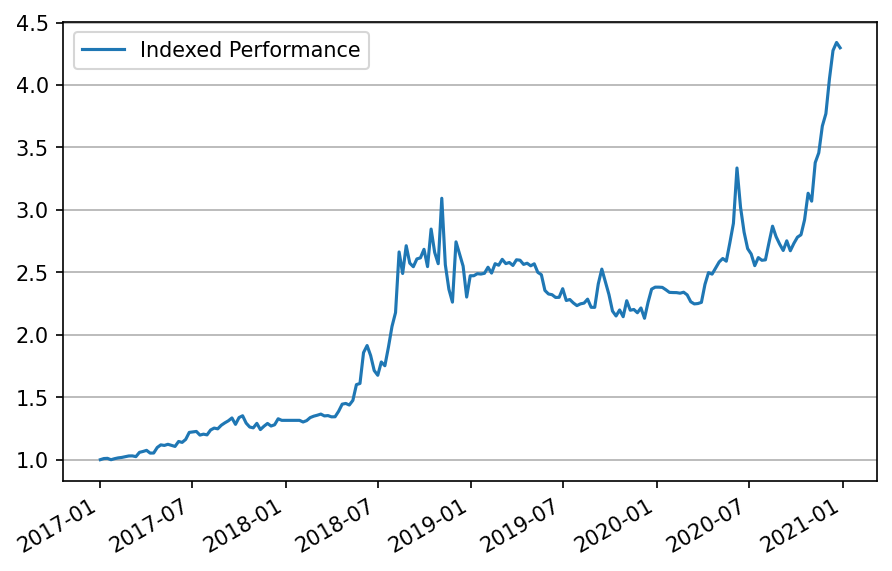

time: 156 ms (started: 2022-10-10 18:17:36 +08:00)


In [29]:
backTest.plot()
plt.grid(axis='y')

# Now loop through model tests and get some statistics to work with.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

time: 0 ns (started: 2022-10-10 18:01:00 +08:00)


# Create the different model pipelines

In [32]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
                          ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# ElasticNet model pipeline
def trainElasticNetModel(X_train, y_train):
    pl_ElasticNet = Pipeline([('Power Transformer', PowerTransformer()),
                              ('ElasticNet', ElasticNet(l1_ratio=0.00001))])
    pl_ElasticNet.fit(X_train, y_train)
    return pl_ElasticNet

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
                              ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))])
    pl_rfregressor.fit(X_train, y_train)   
    return pl_rfregressor

# GradientBoostingRegressor
def traingbregressorModel(X_train, y_train):
    pl_GradBregressor = Pipeline([
        ('GradBoostRegressor',\
         GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,\
                                   max_depth=10, random_state=42, loss='squared_error'))])
    pl_GradBregressor.fit(X_train, y_train)
    return pl_GradBregressor

# # SVM
# def trainsvmModel(X_train, y_train):
#     pl_svm = Pipeline([('Power Transformer', PowerTransformer()),
#                        ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))])
#     pl_svm.fit(X_train, y_train)
#     return pl_svm

time: 0 ns (started: 2022-10-10 18:27:35 +08:00)


## Testing with all the algorithms to see which training size makes sense (0.2 seems ok)

In [14]:
# from the prices data, get the y percentage returns
y_pct = getYPerf(y_withdata)['Perf']

time: 16 ms (started: 2022-10-10 18:01:00 +08:00)


In [33]:
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_GradBregressor', 'pl_rfregressor', 'pl_ElasticNet']

for model in model_pipeline_list:
    for myTstSze in [0.1, 0.2, 0.3]:
        X_train, X_test, y_train, y_test = train_test_split(X, y_pct, test_size=myTstSze)
        
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train, y_train)
        else:
            # Linear model default
            model_pl = trainLinearModel(X_train, y_train) 
            
        y_withdata_test = y_withdata.loc[X_test.index]
        
        # Here is our backtesting code
        backTest = getPortTimeSeries(y_withdata_test, X_test, df_prices, model_pl, verbose=False)
        
        # Find the cumulative performance of the backtest
        perf = backTest['Indexed Performance'][-1]
        
        # Find the volatility of the backtest
        vol = backTest['Indexed Performance'].diff().std()*np.sqrt(52)
        
        print('Performance:', round(perf, 2), 
              'Volatility:', round(vol,2),
              'Test size: ', myTstSze,
              'Model:', model)
    print('\n') 

Performance: 1.93 Volatility: 0.31 Test size:  0.1 Model: pl_linear
Performance: 1.54 Volatility: 0.24 Test size:  0.2 Model: pl_linear
Performance: 1.01 Volatility: 0.27 Test size:  0.3 Model: pl_linear
Performance: 2.55 Volatility: 0.44 Test size:  0.1 Model: pl_KNeighbors
Performance: 1.7 Volatility: 0.29 Test size:  0.2 Model: pl_KNeighbors
Performance: 2.33 Volatility: 0.33 Test size:  0.3 Model: pl_KNeighbors
Performance: 1.34 Volatility: 0.25 Test size:  0.1 Model: pl_decTree
Performance: 1.3 Volatility: 0.17 Test size:  0.2 Model: pl_decTree
Performance: 1.01 Volatility: 0.21 Test size:  0.3 Model: pl_decTree
Performance: 1.43 Volatility: 0.33 Test size:  0.1 Model: pl_GradBregressor
Performance: 4.81 Volatility: 0.73 Test size:  0.2 Model: pl_GradBregressor
Performance: 1.99 Volatility: 0.44 Test size:  0.3 Model: pl_GradBregressor
Performance: 1.18 Volatility: 0.27 Test size:  0.1 Model: pl_rfregressor
Performance: 1.3 Volatility: 0.3 Test size:  0.2 Model: pl_rfregressor
Per

## Now getting the backtesting statistics proper
Can run in parallel, takes awhile.

In [40]:
def getResultsForModel(model_pipeline_list, runs_per_model=1, verbose=True):
    '''
    getResultsForModel
    Choose the model pipelines to run loop for.
    '''
    i, results = 0, []
    for model in model_pipeline_list:
        for test_num in range(0, runs_per_model):
            X_train, X_test, y_train, y_test = train_test_split(X, y_pct, test_size=0.3)
            
            #Train different models
            if (model =='pl_linear'):
                model_pl = trainLinearModel(X_train, y_train)
            if (model =='pl_ElasticNet'):
                model_pl = trainElasticNetModel(X_train, y_train)
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_rfregressor'):
                model_pl = trainrfregressorModel(X_train, y_train)
            if (model =='pl_decTree'):
                model_pl = traindecTreeModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)

            y_withdata_test = y_withdata.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withdata_test, X_test, df_prices, model_pl, verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            if verbose:
                print('Performed test ',i , [i, model, perf, vol])
            results.append([i, model, perf, vol])
            i=i+1

    # Save our results for plotting
    results_df = pd.DataFrame(results, columns=["Test Number",\
                                                "Model Used",\
                                                "Indexed Return",\
                                                "Annual Volatility"])

    # Append to an existing results file if available, 
    # else make new results file.
    # In parallel there is an extremely remote chance 
    # two cores try and access file at same time. 
    # To keep code simple this is OK.
    import os
    if os.path.isfile("Backtest_statistics.csv"):
        results_df.to_csv("Backtest_statistics.csv", 
                          mode='a', 
                          header=False)
    else:
        results_df.to_csv("Backtest_statistics.csv")

time: 0 ns (started: 2022-10-10 22:49:48 +08:00)


In [42]:
# Run with 1 core
#model_pipeline_list = ['pl_KNeighbors']

model_pipeline_list = ['pl_rfregressor', 
                       'pl_decTree', 
                       'pl_linear', 
                       #'pl_GradBregressor', 
                       'pl_KNeighbors', 
                       'pl_ElasticNet']

#model_pipeline_list = ['pl_GradBregressor']
getResultsForModel(model_pipeline_list, 2)

Performed test  0 [0, 'pl_rfregressor', 2.7063604854345873, 0.6007333459540233]
Performed test  1 [1, 'pl_rfregressor', 4.064975569789184, 0.7228392633511072]
Performed test  2 [2, 'pl_decTree', 1.303696367965107, 0.17184892143181707]
Performed test  3 [3, 'pl_decTree', 6.156780412635647, 0.8364561037966936]
Performed test  4 [4, 'pl_linear', 0.7914777018522907, 0.15009261214591008]
Performed test  5 [5, 'pl_linear', 1.6597610473991693, 0.32526761938993126]
Performed test  6 [6, 'pl_KNeighbors', 1.3589504542442743, 0.2552684617475022]
Performed test  7 [7, 'pl_KNeighbors', 2.6173713213760728, 0.5483409678722805]
Performed test  8 [8, 'pl_ElasticNet', 1.2001411247668532, 0.224154875359147]
Performed test  9 [9, 'pl_ElasticNet', 1.6279278600731801, 0.34712812813193306]
time: 2min 54s (started: 2022-10-10 23:15:57 +08:00)


In [51]:
# Run in Parallel
# Specific models on each core
# Can run this many times, will just keep appending to results file.
model_pipeline_list_list = [['pl_GradBregressor', 'pl_ElasticNet'],
                            ['pl_decTree', 'pl_rfregressor'],
                            ['pl_linear', 'pl_KNeighbors']]

import threading
l = len(model_pipeline_list_list)

thread_list = []
for i in range(l):
    thread = threading.Thread(target=getResultsForModel, args=(model_pipeline_list_list[i], 2, False))
    thread_list.append(thread)
    thread.start()
    print('Thread '+str(i)+' started.')

Thread 0 started.
Thread 1 started.
Thread 2 started.
time: 0 ns (started: 2022-10-11 10:53:00 +08:00)


In [70]:
# Can check if threads are still running any time.
# Notebook will look as though nothing is running
# But things are running in background.
for i in thread_list:
    print(i.is_alive())

False
False
False
time: 0 ns (started: 2022-10-11 11:06:16 +08:00)


In [69]:
thread_list

[<Thread(Thread-13, stopped 7008)>,
 <Thread(Thread-14, stopped 29360)>,
 <Thread(Thread-15, stopped 20788)>]

time: 0 ns (started: 2022-10-11 11:06:13 +08:00)


# Investigating Backtest Statistics

In [45]:
results_df = pd.read_csv('Backtest_statistics.csv', index_col=0)
results_df.reset_index(inplace=True, drop=True)

time: 16 ms (started: 2022-10-10 23:26:36 +08:00)


In [46]:
results_df

,Test Number,Model Used,Indexed Return,Annual Volatility
0,0,pl_GradBregressor,1.387645,0.334411
1,1,pl_GradBregressor,2.954307,0.666284
2,0,pl_rfregressor,2.706360,0.600733
3,1,pl_rfregressor,4.064976,0.722839
4,2,pl_decTree,1.303696,0.171849
5,3,pl_decTree,6.156780,0.836456
6,4,pl_linear,0.791478,0.150093
7,5,pl_linear,1.659761,0.325268
8,6,pl_KNeighbors,1.358950,0.255268
9,7,pl_KNeighbors,2.617371,0.548341


time: 47 ms (started: 2022-10-10 23:26:37 +08:00)


In [65]:
def plotBacktestDist(results_df, model_file, col):
    ax=results_df[results_df['Model Used']==model_file][col].hist(\
                                    bins=50, density=True, alpha=0.7)
    
    ax2=results_df[results_df['Model Used']==model_file][col].plot.kde(alpha=0.9)
    
    max_val=results_df[results_df['Model Used']==model_file][col].max()
    ax.set_xlabel(col)
    ax.set_ylabel('Normalised Frequency')
    ax.set_title('{} Backtest Distribution for {}, {} Runs'.format(\
          col,\
          model_file,\
          results_df[results_df['Model Used']==model_file][col].size))
    ax.grid()
    mean=results_df[results_df['Model Used']==model_file][col].mean()
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns
        # begin 2010 -> end 2020
        ax.plot([3.511822, 3.511822], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=1.5, alpha=1)
        plt.xlim(0, 10)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility
        # begin 2010 -> end 2020
        ax.plot([0.325059094152396, 0.325059094152396], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=2)  
        plt.xlim(0, 1.5)
    ax.legend(['Fitted Smooth Kernel','S&P500 Benchmark', \
               'Simulation Mean {}'.format(round(mean,2)),\
               'Simulation Backtests'])

time: 0 ns (started: 2022-10-11 11:00:12 +08:00)


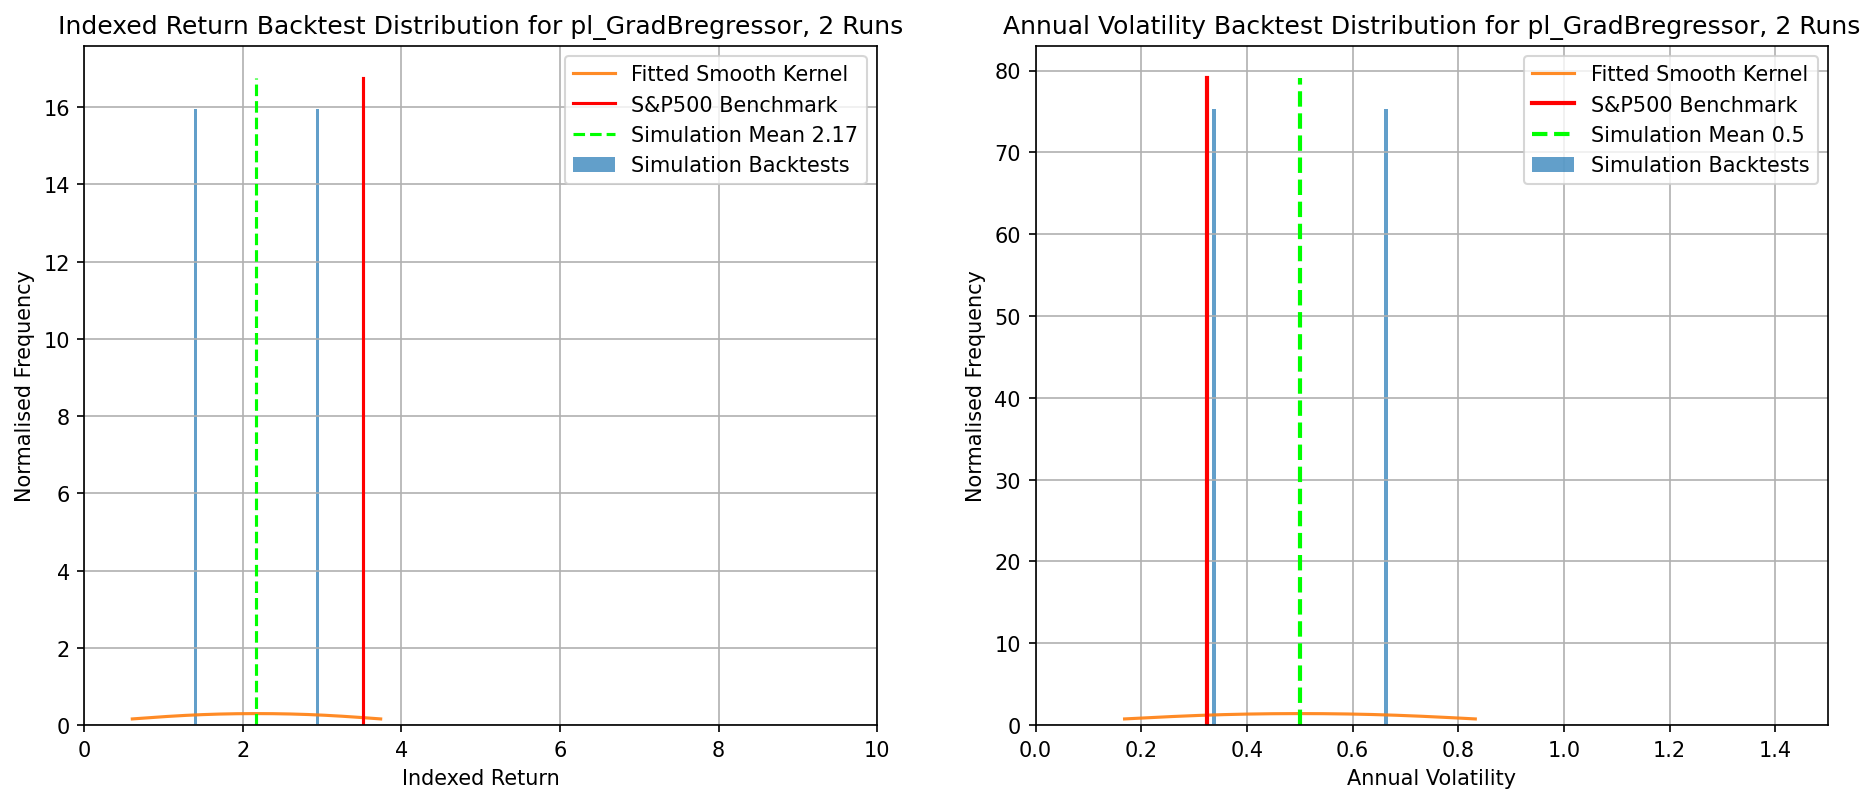

time: 750 ms (started: 2022-10-11 11:00:15 +08:00)


In [66]:
model_file = 'pl_GradBregressor' #['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors']
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')

plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

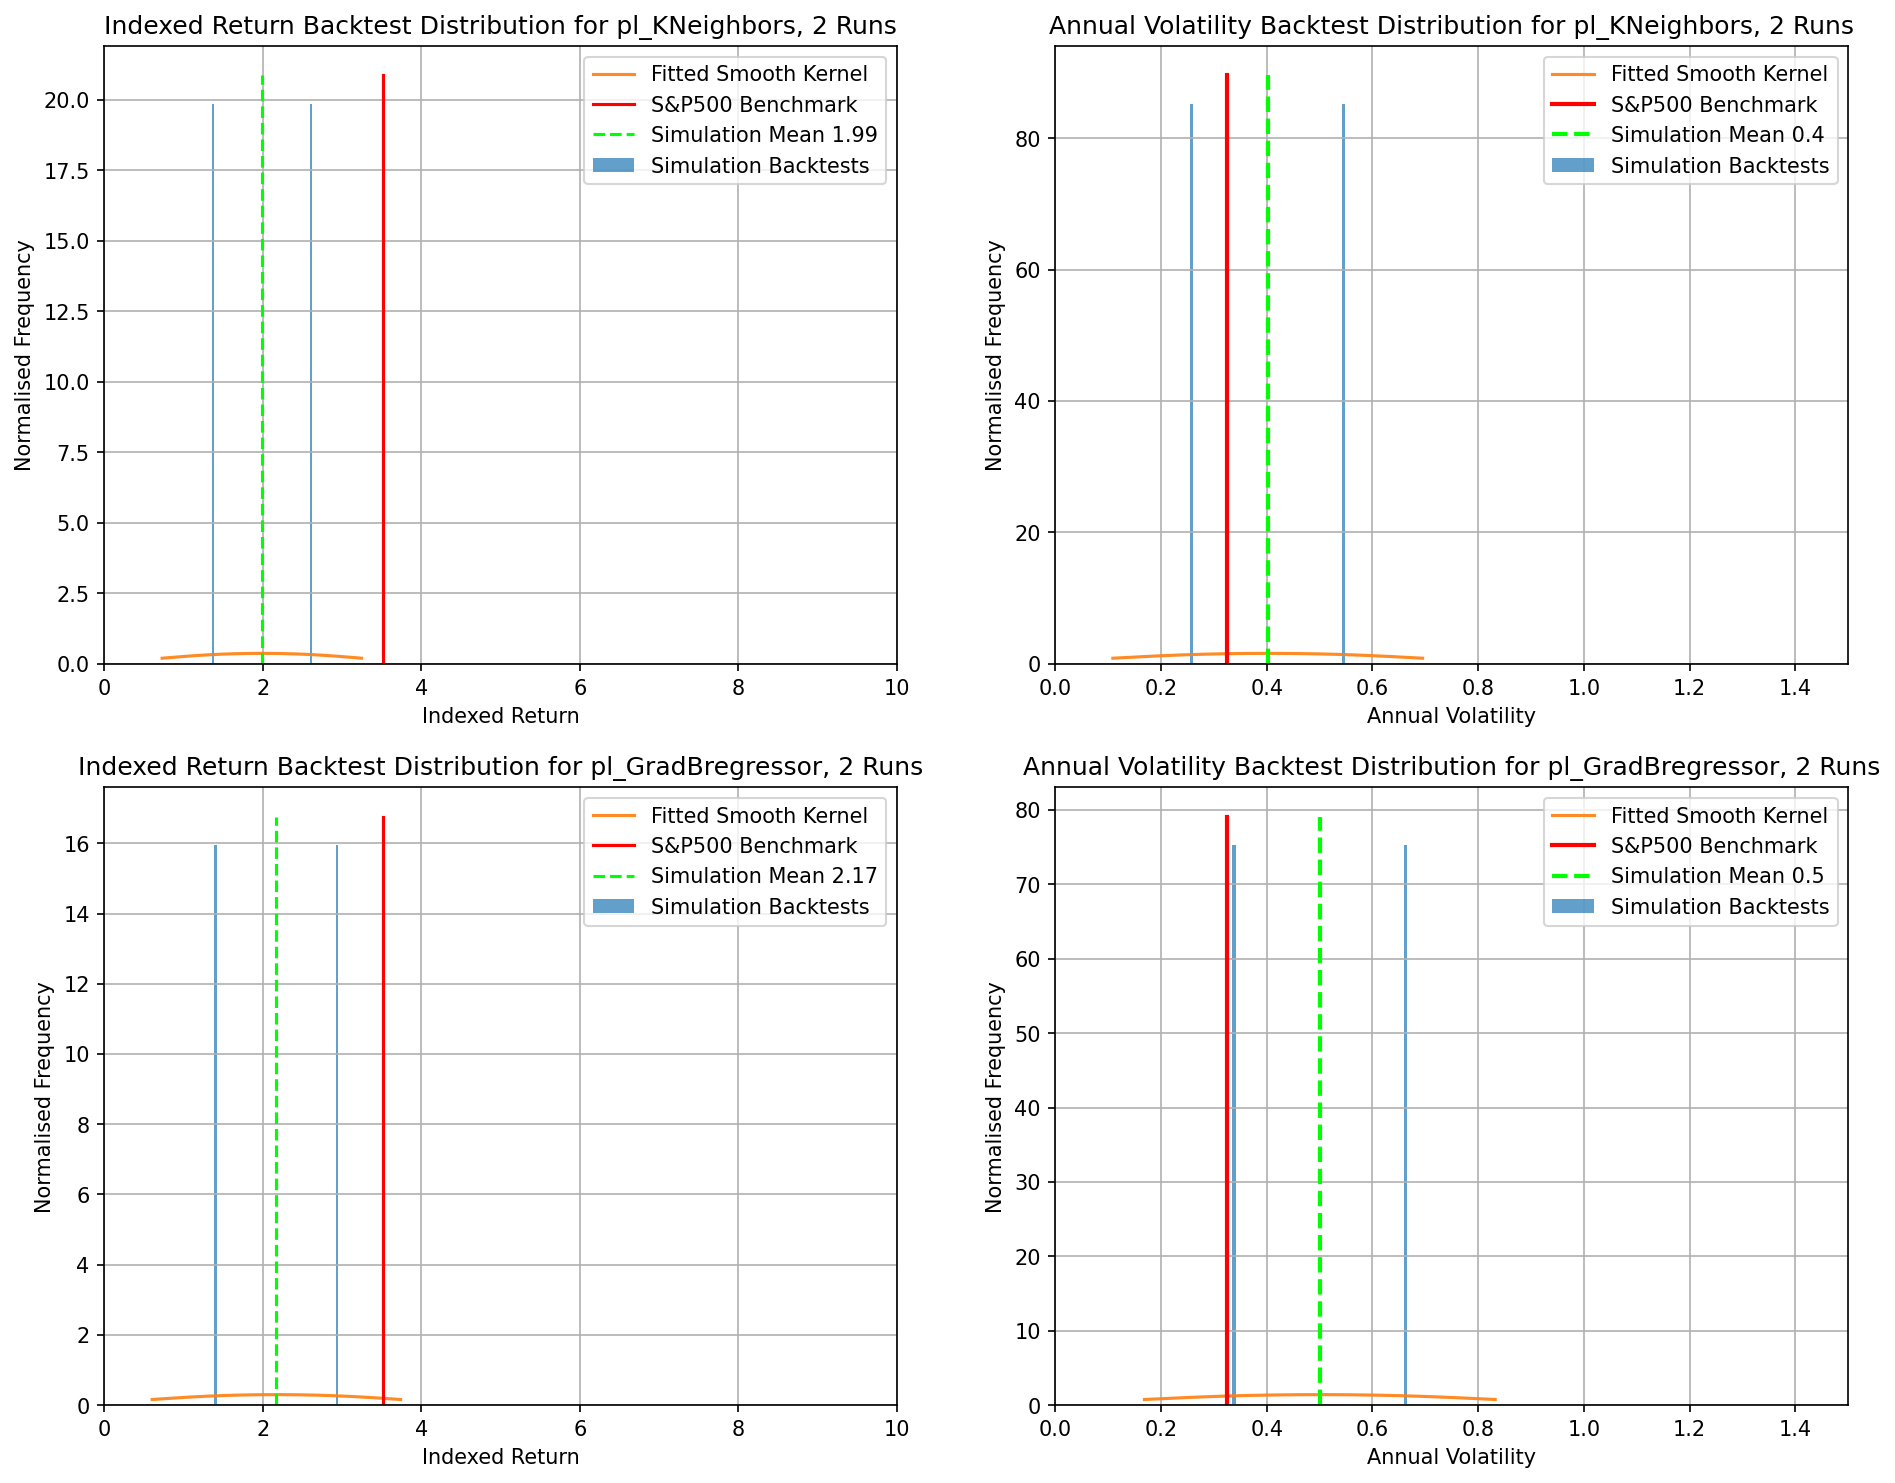

time: 27.7 s (started: 2022-10-10 23:28:13 +08:00)


In [49]:
#model_file = ['pl_ElasticNet','pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_linear', 'pl_ElasticNet']
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm']
model_file = ['pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_rfregressor']
numPlots = len(model_file)
plt.figure(figsize=(15,6*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Chosen Regressors for AI are GradBoost and KNN

We will expect more volatility.

Text(0.5, 1.0, 'KNN Backtest Return vs. Volatility')

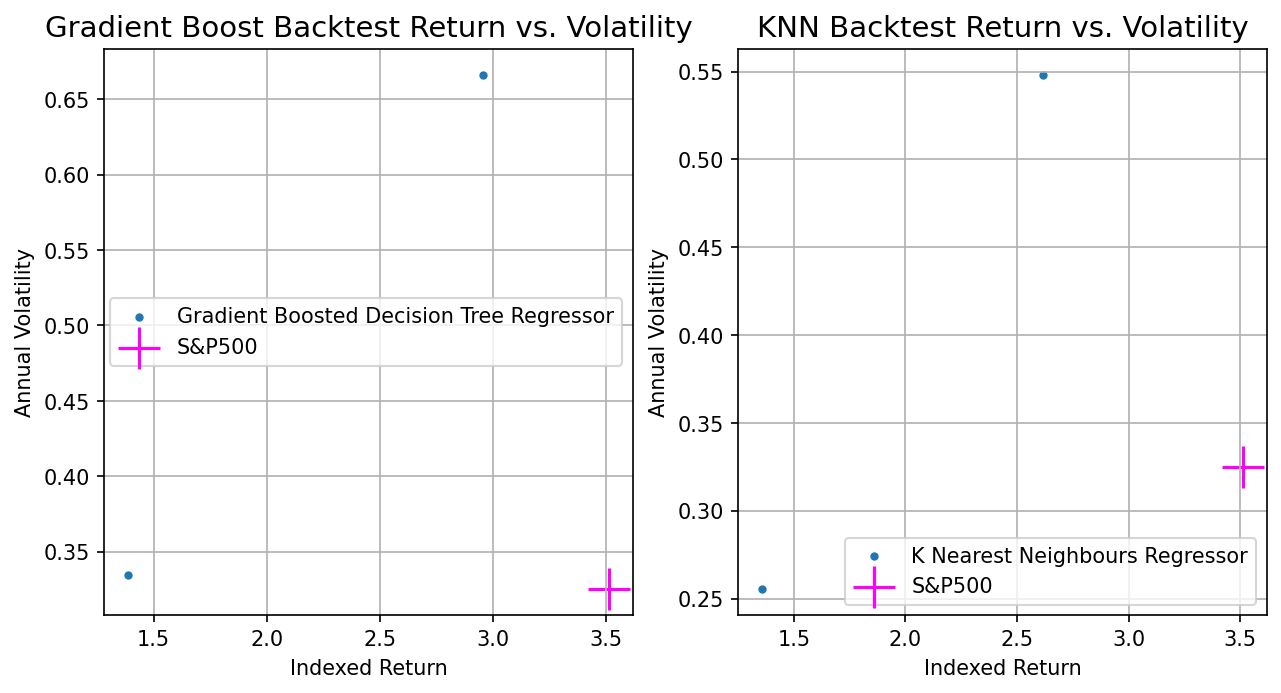

time: 2.08 s (started: 2022-10-11 11:00:27 +08:00)


In [67]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['Gradient Boosted Decision Tree Regressor', 'S&P500'])
plt.title('Gradient Boost Backtest Return vs. Volatility', fontsize=14)

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['K Nearest Neighbours Regressor', 'S&P500'])
plt.title('KNN Backtest Return vs. Volatility', fontsize=14)

Text(0.5, 0, 'Annual Volatility')

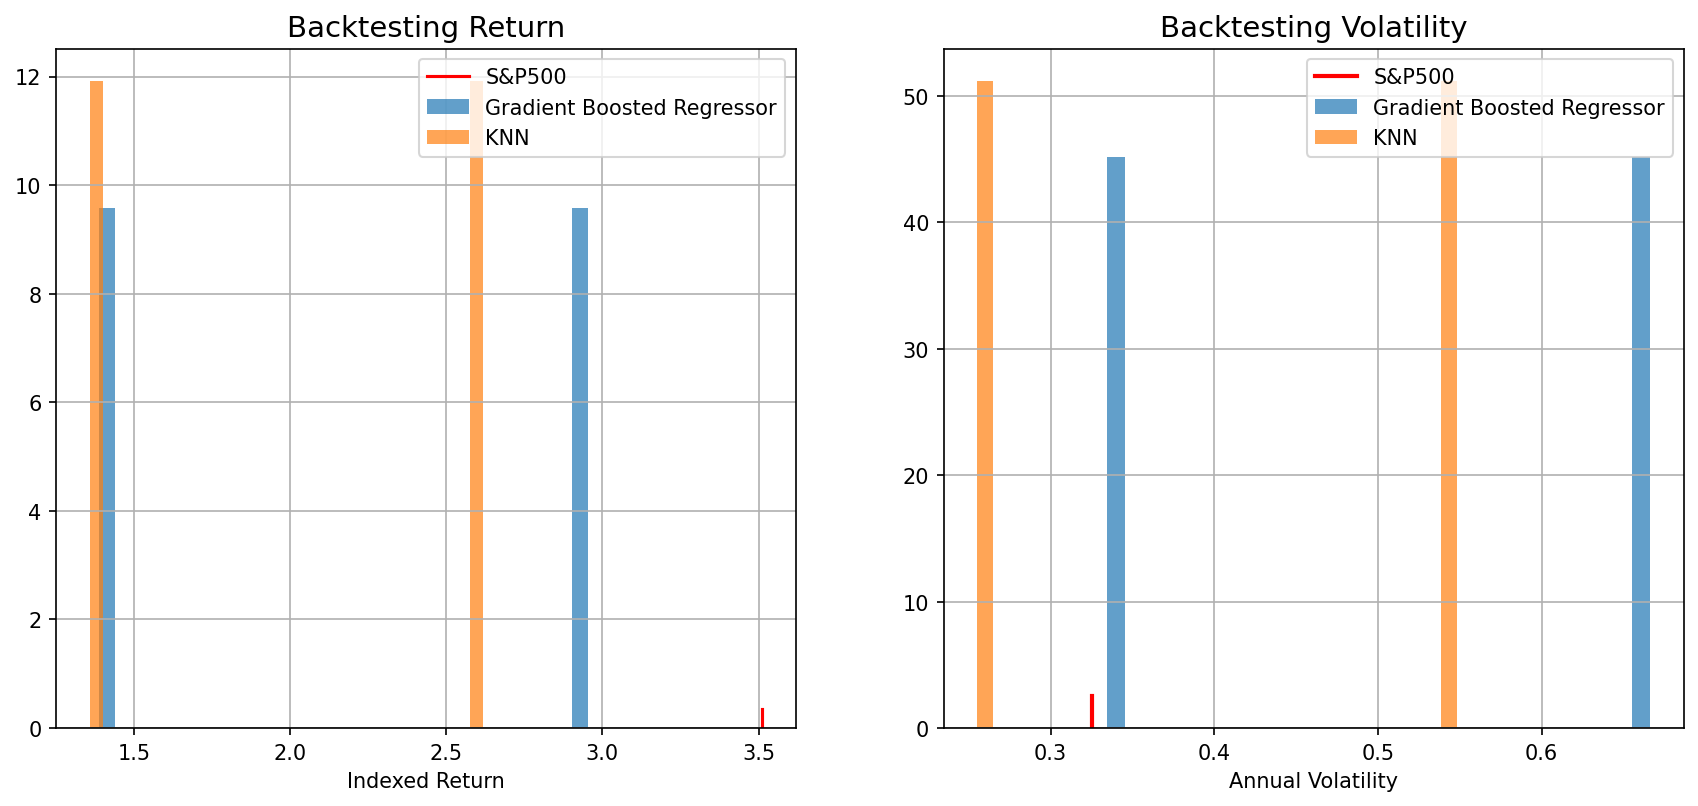

time: 3.77 s (started: 2022-10-11 11:00:50 +08:00)


In [68]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([3.511822, 3.511822], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Return', fontsize=14)
plt.xlabel('Indexed Return')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([0.325059094152396, 0.325059094152396], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Volatility', fontsize=14)
plt.xlabel('Annual Volatility')

# Figure out what the actual performance should be

In [ ]:
# Choose the model pipelines to run loop for
model_pipeline_list = ['pl_GradBregressor', 'pl_KNeighbors']
tests_per_model=20

# Reduce test size and check performance to try and see a trend
# Is effectively *0.5 as test size is 1/2 of total data.
#test_size_modifier_list = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05 ]
test_size_modifier_list = [0.05, 0.075]

# Results DataFrame
results_df2 = pd.DataFrame( columns=["Test Number",
                                            "Model Used",\
                                            "Test Set Size",\
                                            "Indexed Return",\
                                            "Annual Volatility"])

i, results = 0, []
for model in model_pipeline_list:
    for test_size_mod in test_size_modifier_list:
        for test_num in range(0, tests_per_model):
            
            X_train, X_test, y_train, y_test = \
            train_test_split(X, y_pec, test_size=0.5)
            
            new_test_size = round(len(X_test)//(1/test_size_mod))
            
            X_test, y_test = \
            X_test[:new_test_size], y_test[:new_test_size]
            
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withData_Test, X_test,
                     daily_stock_prices, model_pl, 
                         verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            #print('Performed test ',i , [i, model, new_test_size, perf, vol])     
            
            results_df2=results_df2.append(\
                        pd.DataFrame(\
                             [[i, model, new_test_size, perf, vol]],\
                                     columns=results_df2.keys()))      
            i=i+1
            
        print('For {} test size {}, Performance: {}, Vol: {}.'.format(\
              model, new_test_size, \
            results_df2['Indexed Return'].tail(tests_per_model).mean(),\
            results_df2['Annual Volatility'].tail(tests_per_model).mean()))

# Save our results for plotting
results_df2.to_csv("Backtest_statistics_Modified_test_size.csv")

In [ ]:
test_set_size = [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05]
gradB_avgReturn = [4.23, 4.44, 3.39, 3.6, 3.29, 3.42, 3.42]
knn_avgReturn = [4.68, 4.32, 4.49, 3.83, 3.30, 3.31, 2.85]


plt.figure(figsize=(12,4))

linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(gradB_avgReturn).reshape(-1,1))
plt.subplot(1,2,1)
plt.scatter(test_set_size, gradB_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('GradBoost Decision Tree\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(knn_avgReturn).reshape(-1,1))
plt.subplot(1,2,2)
plt.scatter(test_set_size, knn_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('K-Nearest Neighbours\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


# Final Stock Selection for 2020 with Gradient Boosted Decision Tree and K Nearest Neighbours

In [ ]:
def pickStockForMe(model='GBoost'):
    '''
    Pick stocks.
    Reads Annual_Stock_Price_Fundamentals_Ratios.csv,
    and Annual_Stock_Price_Performance_Percentage.csv,
    trains the AI with the best model/parameters,
    Then picks stocks using outputs from Notebooks 1 and 2:
    Annual_Stock_Price_Fundamentals_Ratios_2021.csv,
    and Tickers_Dates_2021.csv.
    Outputs a DataFrame of best picks.
    '''
    # Training X and Y of all previous year data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
                  index_col=0)
    # annual stock performances
    yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", 
                      index_col=0)
    
    yperf=yperf["Perf"]

    # Stock selection ratios for 2021 X
    X_2021=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_2021.csv"
                       , index_col=0)
    # And the row tickers
    tickers=pd.read_csv("Tickers_Dates_2021.csv", index_col=0)
    
    if model == 'GBoost':
        # Gradient Boosted tree
        model_pl = traingbregressorModel(X, yperf)
        y_pred=model_pl.predict(X_2021)
        y_pred=pd.DataFrame(y_pred)
    
    elif model == 'KNN':
        # KNN
        model_pl = trainKNeighborsModel(X, yperf)
        y_pred=model_pl.predict(X_2021)
        y_pred=pd.DataFrame(y_pred)
    
    else:
        return None

    # FINAL STOCK PICKS
    # Separate out stocks with low Z scores
    # 3.75 is approx. B- rating
    z = calcZScores(X_2021)
    zbl = (z['Z score'].reset_index(drop=True) > 2) 

    Final_Predictions = pd.DataFrame()
    Final_Predictions[['Ticker','Report Date']] = \
    tickers[['Ticker','Date']].reset_index(drop=True)\
                               [zbl].reset_index(drop=True)
    
    Final_Predictions['Perf. Score'] = y_pred.reset_index(drop=True)\
                                       [zbl].reset_index(drop=True)

    return Final_Predictions.sort_values(by='Perf. Score', 
                                         ascending=False)\
                                    .reset_index(drop=True).head(20)

In [ ]:
# What it's all about.
pickStockForMe()

In [ ]:
pickStockForMe('KNN')